In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DICOMCoarseDataset

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["nodule", "non-nodule"]
train_ratio = 0.6
scenario = 3

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

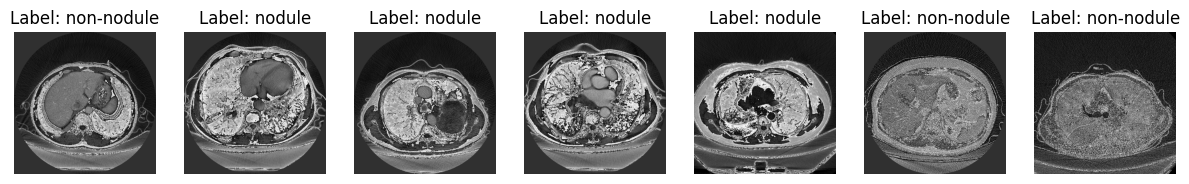

In [3]:
dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=scenario)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_images(num_images=7)

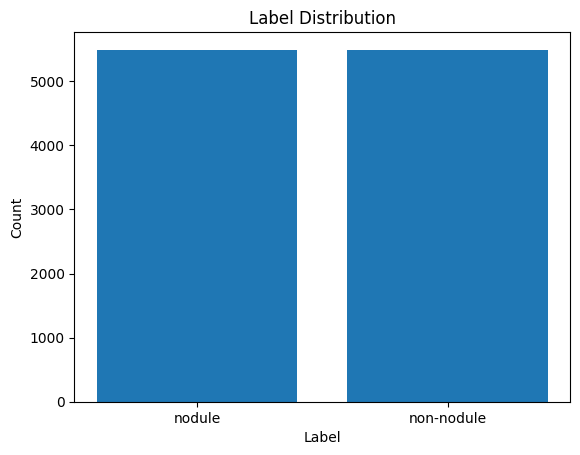

In [4]:
dataset.display_label_distribution()

In [5]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 6591 --- Validation size: 2197 --- Test size: 2198


In [6]:
model_names = ["resnet", "densenet", "inception", "efficientnet", "efficientnet2", "efficientnet3", "vit"]
best_val_loss = float('inf')
best_model = None

for model_name in model_names:
    print(f"Processing model: {model_name}")
    current_model = TransferLearningModel(classes, model_name, data_augmentation=True, fine=False, scenario=scenario)

    # Ensure transforms are correctly applied based on model requirements
    current_model.train_transforms, current_model.test_transforms = current_model.get_transforms()
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Apply specific transforms to each subset
    train_dataset.dataset.transform = current_model.train_transforms
    val_dataset.dataset.transform = current_model.test_transforms
    test_dataset.dataset.transform = current_model.test_transforms

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10)

    # Train the current model
    current_model.train(train_loader, val_loader, early_stopping, epochs=50)

    # Track the best model based on validation loss
    final_val_loss = current_model.val_losses[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = current_model

print(f"The best model is {best_model.model_name} with a validation loss of {best_val_loss:.4f}")

Processing model: resnet
Epoch 1/50 ----- Loss: 0.6343, Accuracy: 63.47% ----- Validation Loss: 0.5915, Validation Accuracy: 68.14%
Epoch 2/50 ----- Loss: 0.5900, Accuracy: 68.05% ----- Validation Loss: 0.5739, Validation Accuracy: 70.51%
Epoch 3/50 ----- Loss: 0.5729, Accuracy: 69.72% ----- Validation Loss: 0.5709, Validation Accuracy: 71.19%
Epoch 4/50 ----- Loss: 0.5603, Accuracy: 71.25% ----- Validation Loss: 0.6075, Validation Accuracy: 69.28%
Epoch 5/50 ----- Loss: 0.5530, Accuracy: 71.61% ----- Validation Loss: 0.5593, Validation Accuracy: 71.83%
Epoch 6/50 ----- Loss: 0.5750, Accuracy: 69.73% ----- Validation Loss: 0.5696, Validation Accuracy: 71.83%
Epoch 7/50 ----- Loss: 0.5417, Accuracy: 71.81% ----- Validation Loss: 0.5531, Validation Accuracy: 71.83%
Epoch 8/50 ----- Loss: 0.5454, Accuracy: 72.02% ----- Validation Loss: 0.5488, Validation Accuracy: 71.60%
Epoch 9/50 ----- Loss: 0.5345, Accuracy: 72.75% ----- Validation Loss: 0.5633, Validation Accuracy: 72.10%
Epoch 10/50 

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\.venv\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/50 ----- Loss: 0.5885, Accuracy: 68.24% ----- Validation Loss: 0.5901, Validation Accuracy: 66.09%
Epoch 2/50 ----- Loss: 0.5318, Accuracy: 73.05% ----- Validation Loss: 0.5293, Validation Accuracy: 71.28%
Epoch 3/50 ----- Loss: 0.5113, Accuracy: 74.01% ----- Validation Loss: 0.5093, Validation Accuracy: 74.19%
Epoch 4/50 ----- Loss: 0.4989, Accuracy: 75.36% ----- Validation Loss: 0.5083, Validation Accuracy: 75.56%
Epoch 5/50 ----- Loss: 0.4908, Accuracy: 75.82% ----- Validation Loss: 0.5095, Validation Accuracy: 73.28%
Epoch 6/50 ----- Loss: 0.4820, Accuracy: 75.97% ----- Validation Loss: 0.4981, Validation Accuracy: 75.97%
Epoch 7/50 ----- Loss: 0.4705, Accuracy: 77.04% ----- Validation Loss: 0.4973, Validation Accuracy: 75.47%
Epoch 8/50 ----- Loss: 0.4709, Accuracy: 77.15% ----- Validation Loss: 0.5244, Validation Accuracy: 72.33%
Epoch 9/50 ----- Loss: 0.4714, Accuracy: 76.94% ----- Validation Loss: 0.4967, Validation Accuracy: 75.83%
Epoch 10/50 ----- Loss: 0.4647, Accur

Best model: efficientnet3


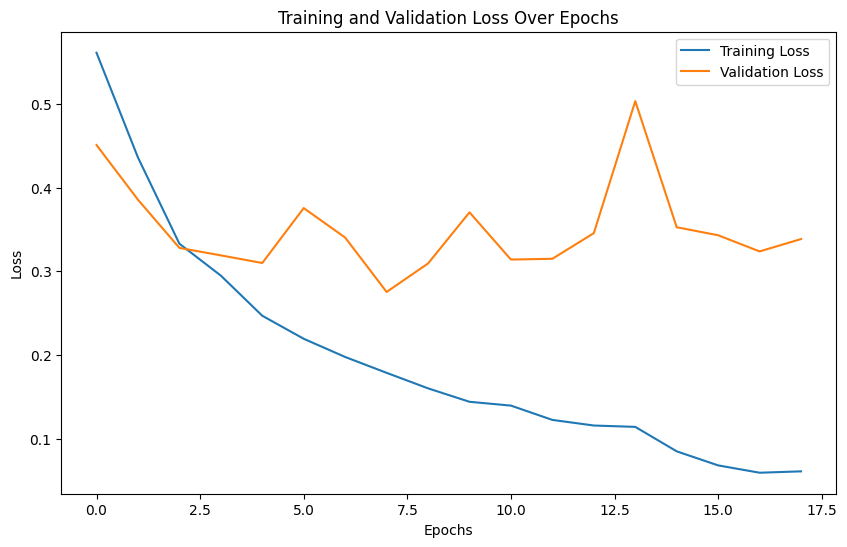

In [7]:
print(f"Best model: {best_model.model_name}")
best_model.plot_loss()

Best model: efficientnet3
0.31008770423663656
Evaluation Accuracy on unseen data: 92.49317561419473


<Figure size 1000x800 with 0 Axes>

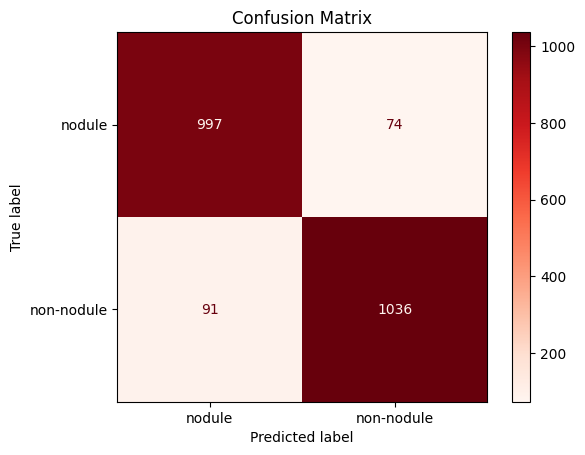

In [8]:
print(f"Best model: {best_model.model_name}")
checkpoint = torch.load(f"weights/coarse/scenario{scenario}/{best_model.model_name}.pt", weights_only=False)
best_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
best_model.evaluate(test_loader)

0.47684017367725434
Evaluation Accuracy on unseen data: 78.79890809827116


<Figure size 1000x800 with 0 Axes>

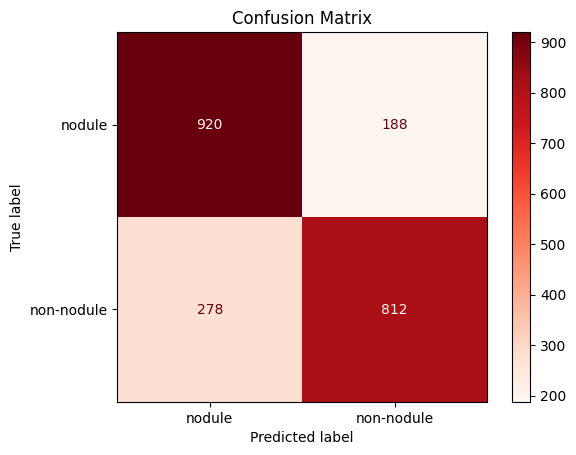

In [ ]:
# test_model_name = "vit"
# test_model = TransferLearningModel(classes, test_model_name, data_augmentation=False, scenario=3)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=1)
# train_size = int(train_ratio * len(dataset))
# val_size = int(((1-train_ratio)/2) * len(dataset)) 
# test_size = len(dataset) - train_size - val_size
# # Ensure transforms are correctly applied based on model requirements
# test_model.train_transforms, test_model.test_transforms = test_model.get_transforms()
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# test_dataset.dataset.transform = test_model.test_transforms

# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# checkpoint = torch.load(f"weights/coarse/scenario3/augmented_{test_model.model_name}.pt", weights_only=False)
# test_model.model.load_state_dict(checkpoint['model_state_dict'])
# loss = checkpoint["loss"]
# print(loss)
# test_model.evaluate(test_loader)